Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")

# 2. Import Custom Modules

from src.data_loader_temp import ClinicalTrialLoader
from src.preprocessing_temp import get_pipeline


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


 Smart Data Loading (Auto-Generation)

In [3]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> File not found (or forced regeneration). Triggering ETL pipeline...
>>> 1. Loading Studies & Applying Filters...
    Core Cohort: 119166 trials
>>> 2. Engineering Features...
    -> Engineering Sponsor Tiers & Experience...
    -> Engineering Protocol Complexity & Eligibility...
>>> Saved 105850 rows to /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (105850, 36)


In [4]:
df.columns

Index(['nct_id', 'start_date_type', 'start_date', 'study_type',
       'overall_status', 'phase', 'number_of_arms', 'why_stopped', 'target',
       'start_year', 'phase_ordinal', 'sample_weight', 'covid_exposure',
       'includes_us', 'is_international', 'allocation', 'intervention_model',
       'primary_purpose', 'masking', 'num_primary_endpoints', 'lead_sponsor',
       'agency_class', 'sponsor_clean', 'sponsor_tier',
       'sponsor_experience_log', 'gender', 'healthy_volunteers', 'adult',
       'child', 'older_adult', 'criteria_len_log', 'best_pathology',
       'therapeutic_area', 'therapeutic_subgroup_name', 'competition_broad',
       'competition_niche'],
      dtype='object')

Temporal Split (Time Travel) <br>
Why: We sort by date to ensure strict separation of Past (Train) and Future (Test).

In [5]:
# 1. Sort & Split
df = df.sort_values('start_year').reset_index(drop=True)
split_idx = int(len(df) * 0.7)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

# 2. Define Features
target_col = 'target'

# DROP 'sponsor_risk' (it doesn't exist yet)
# KEEP 'sponsor_clean' (The pipeline needs the text)
drop_cols = [target_col, 'overall_status', 'nct_id', 'sample_weight']

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]
train_weights = train_df['sample_weight']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df[target_col]

print("Ready for Training. The Pipeline will handle the Sponsor Risk math.")

Ready for Training. The Pipeline will handle the Sponsor Risk math.


dummy classifier (basline assessment)

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("--- BASELINE: DUMMY CLASSIFIER ---")

# 1. Create & Fit (Strategy: Always predict the majority class)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)

# 2. Predict
y_pred_dummy = dummy.predict(X_test)

# 3. Basic Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
# Note: Precision/Recall will likely be 0.0 if the majority class is 0 (Completed)
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print("\nInterpretation: This is the score you get by doing absolutely nothing.")

--- BASELINE: DUMMY CLASSIFIER ---
Accuracy:  0.7375
Precision: 0.0000
Recall:    0.0000

Interpretation: This is the score you get by doing absolutely nothing.


Model training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1. Build Pipeline
model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        penalty='l2',
        C=0.01,
        max_iter=1000,
        random_state=42
    ))
])

# 2. Fit with Weights
print(f"Training Logistic Regression on {len(X_train)} trials...")

# CHANGE: Pass the weights here!
model.fit(X_train, y_train, classifier__sample_weight=train_weights)

print("Training Complete.")

Training Logistic Regression on 74095 trials...
Training Complete.


Evaluation & Visualization

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- MODEL PERFORMANCE METRICS ---
ROC-AUC Score:      0.7169  (0.5 = Random, 1.0 = Perfect)
PR-AUC Score:       0.4509   (Baseline: 0.2625)
----------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.90      0.40      0.56     23420
           1       0.34      0.88      0.50      8335

    accuracy                           0.53     31755
   macro avg       0.62      0.64      0.53     31755
weighted avg       0.76      0.53      0.54     31755



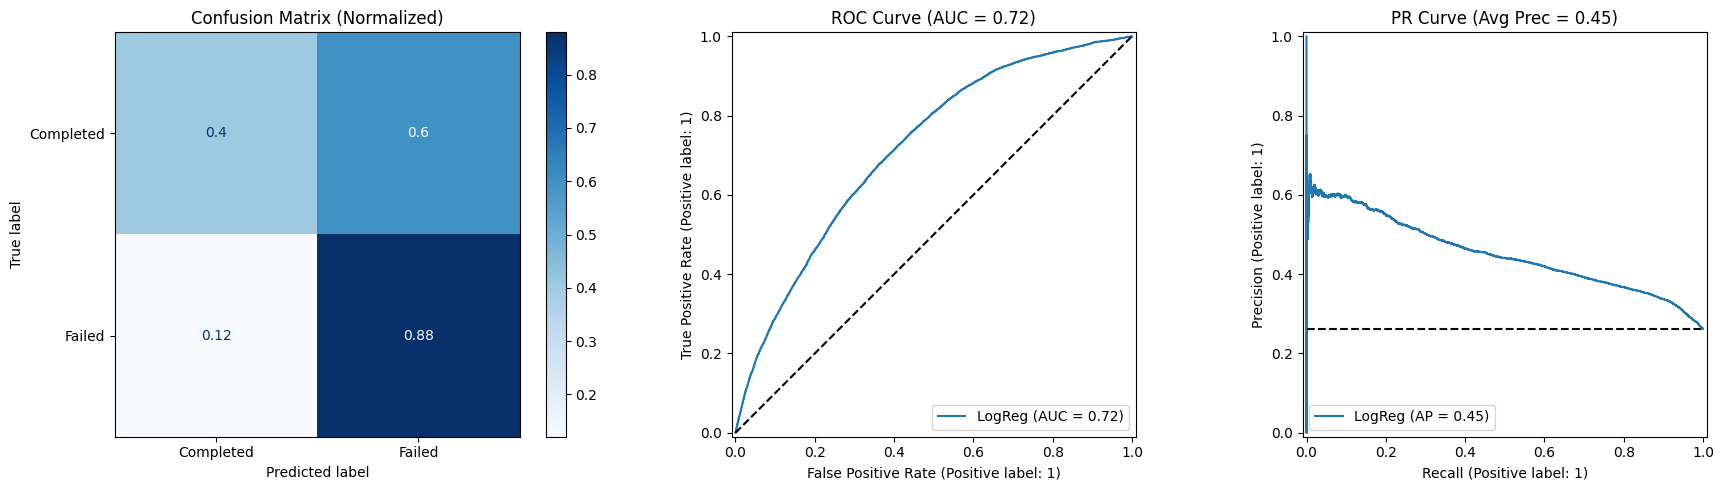

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay)

# 1. Get Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Calculate Advanced Metrics
roc_score = roc_auc_score(y_test, y_prob)
pr_score = average_precision_score(y_test, y_prob)

print(f"--- MODEL PERFORMANCE METRICS ---")
print(f"ROC-AUC Score:      {roc_score:.4f}  (0.5 = Random, 1.0 = Perfect)")
print(f"PR-AUC Score:       {pr_score:.4f}   (Baseline: {y_test.mean():.4f})")
print("-" * 40)
print("CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# 3. Visualizations
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# A. Confusion Matrix (Normalized)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    normalize='true',
    cmap='Blues',
    display_labels=['Completed', 'Failed'],
    ax=ax[0]
)
ax[0].set_title("Confusion Matrix (Normalized)")

# B. ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob, ax=ax[1], name='LogReg')
ax[1].set_title(f"ROC Curve (AUC = {roc_score:.2f})")
ax[1].plot([0, 1], [0, 1], "k--", label="Chance")

# C. Precision-Recall Curve
PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=ax[2], name='LogReg')
ax[2].set_title(f"PR Curve (Avg Prec = {pr_score:.2f})")
ax[2].plot([0, 1], [y_test.mean(), y_test.mean()], "k--", label="Baseline")

plt.tight_layout()
plt.show()

## "Vintage Analysis" or "Model Shelf-Life Analysis." (Walk-Forward Validation)
 Instead of training once on 2000-2019 and testing on 2019-2024, you retrain the model every year. This mimics real life: in 2020, you would have retrained your model using data up to 2019.

Save Model <br>
Why: Saves the trained pipeline so the Streamlit app can load it later.

Running Vintage Analysis for 8 iterations (2017 - 2024)...


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be en


--- COMPACT PERFORMANCE TABLE (Fresh Model Performance) ---
Model Vintage   | Test Year  | AUC      | Precision  | Recall  
-----------------------------------------------------------------
< 2017          | 2017       | 0.6709   | 0.2704     | 0.8365
< 2018          | 2018       | 0.6898   | 0.3047     | 0.8594
< 2019          | 2019       | 0.7121   | 0.3056     | 0.9242
< 2020          | 2020       | 0.7184   | 0.3392     | 0.8959
< 2021          | 2021       | 0.7526   | 0.3809     | 0.9107
< 2022          | 2022       | 0.7911   | 0.4304     | 0.8589
< 2023          | 2023       | 0.8306   | 0.4170     | 0.9029
< 2024          | 2024       | 0.8611   | 0.4617     | 0.8825
-----------------------------------------------------------------


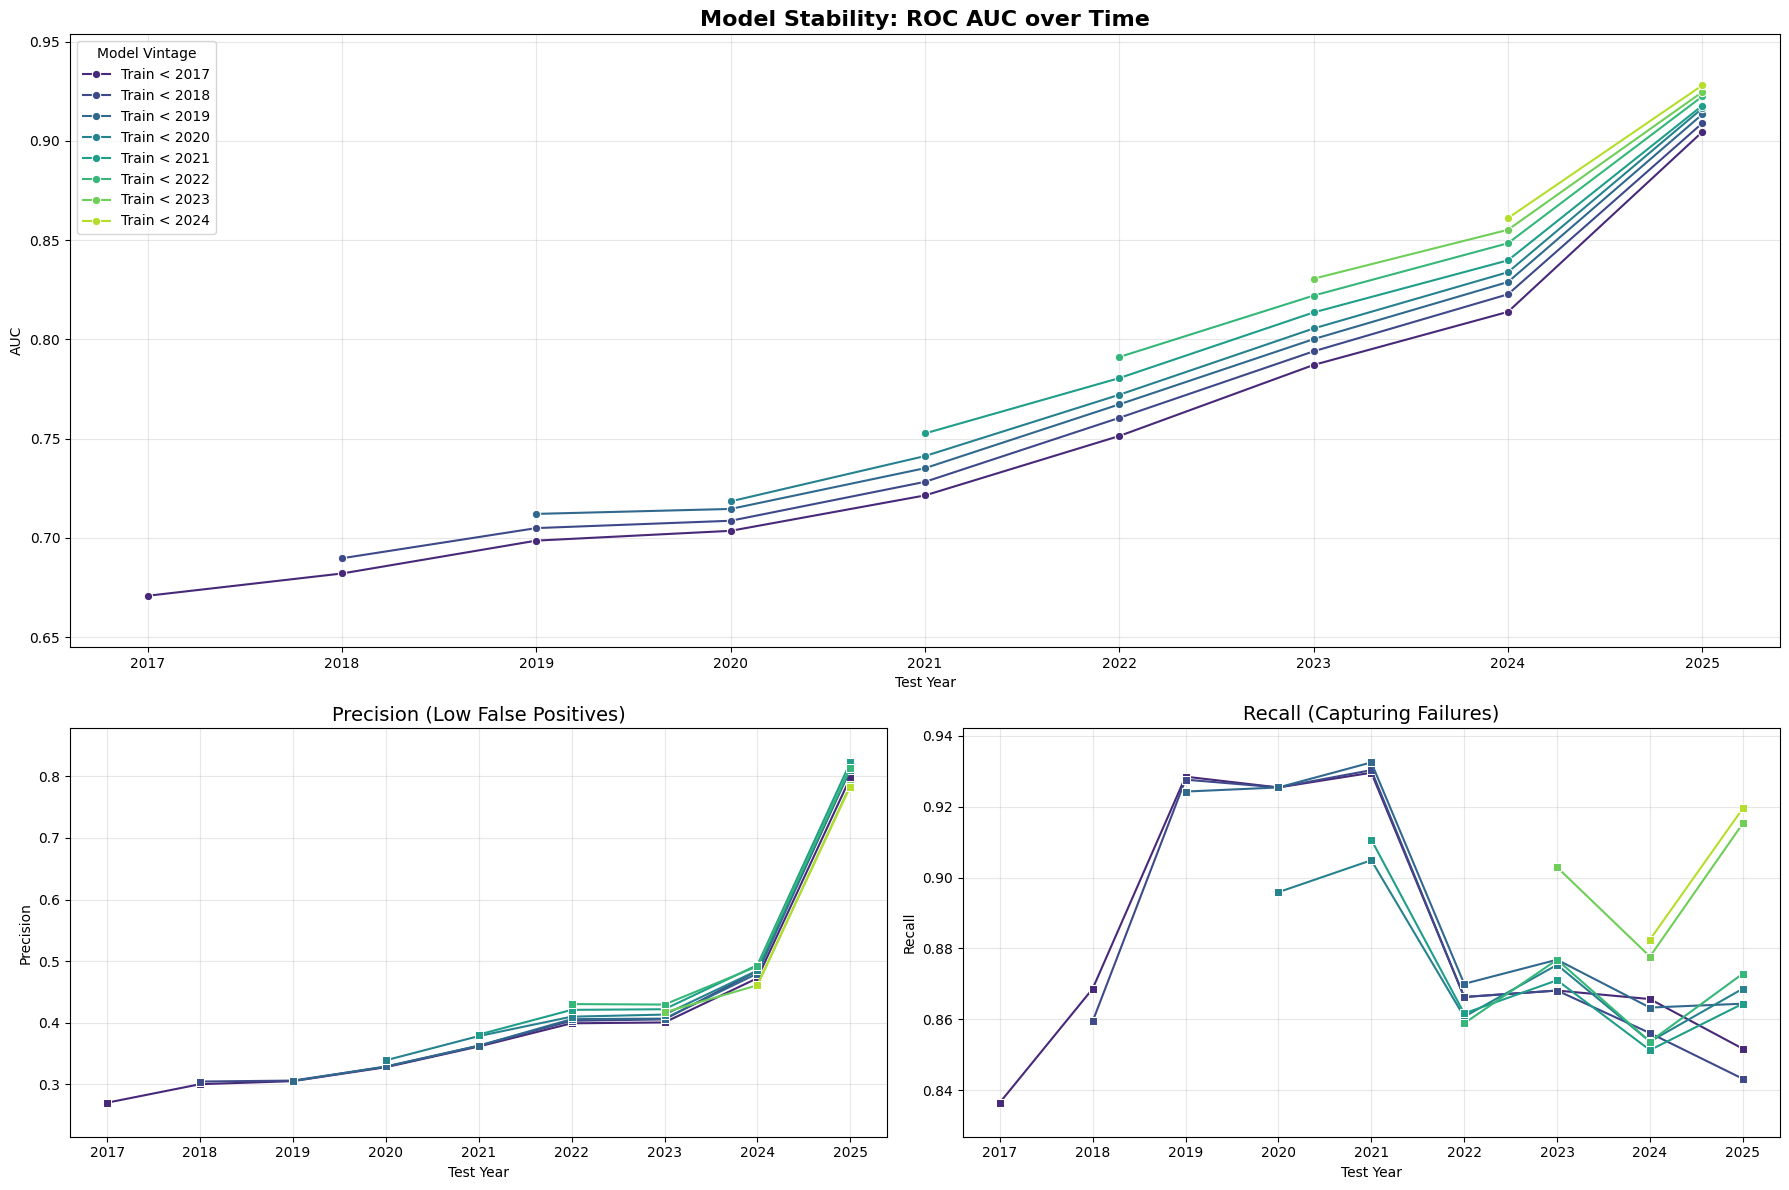

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def plot_compact_vintage_dashboard(pipeline, df, start_cutoff=2017, iterations=8):
    results = []
    compact_table_data = []

    cutoffs = [start_cutoff + i for i in range(iterations)]

    print(f"Running Vintage Analysis for {iterations} iterations ({start_cutoff} - {cutoffs[-1]})...")

    for cutoff in cutoffs:
        # 1. Train/Test Split
        train_mask = df['start_year'] < cutoff
        test_mask = df['start_year'] >= cutoff

        train_df = df[train_mask]
        future_df = df[test_mask]

        # Stop if no future data
        if len(future_df) < 50:
            break

        X_train = train_df.drop(columns=['target', 'overall_status', 'nct_id'])
        y_train = train_df['target']

        # 2. Fit Model
        current_model = clone(pipeline)
        current_model.fit(X_train, y_train)

        # 3. Test Loop
        future_years = sorted(future_df['start_year'].unique())

        for test_year in future_years:
            year_data = future_df[future_df['start_year'] == test_year]

            if len(year_data) < 50 or year_data['target'].nunique() < 2:
                continue

            X_test = year_data.drop(columns=['target', 'overall_status', 'nct_id'])
            y_test = year_data['target']

            probs = current_model.predict_proba(X_test)[:, 1]
            preds = current_model.predict(X_test)

            auc = roc_auc_score(y_test, probs)
            prec = precision_score(y_test, preds, zero_division=0)
            rec = recall_score(y_test, preds, zero_division=0)

            # Store for Plotting
            results.append({
                'Model Version': f"Train < {cutoff}",
                'Test Year': int(test_year),
                'AUC': auc,
                'Precision': prec,
                'Recall': rec
            })

            # Store for Compact Table (Only the "Fresh" score: Test Year == Cutoff)
            if int(test_year) == cutoff:
                compact_table_data.append({
                    'Model Vintage': f"< {cutoff}",
                    'Test Year': int(test_year),
                    'AUC': auc,
                    'Precision': prec,
                    'Recall': rec
                })

    # --- 4. COMPACT TABLE PRINTING ---
    print("\n--- COMPACT PERFORMANCE TABLE (Fresh Model Performance) ---")
    print(f"{'Model Vintage':<15} | {'Test Year':<10} | {'AUC':<8} | {'Precision':<10} | {'Recall':<8}")
    print("-" * 65)
    for row in compact_table_data:
        print(f"{row['Model Vintage']:<15} | {row['Test Year']:<10} | {row['AUC']:.4f}   | {row['Precision']:.4f}     | {row['Recall']:.4f}")
    print("-" * 65)

    # --- 5. VISUALIZATION ---
    res_df = pd.DataFrame(results)

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 1])

    ax_main = fig.add_subplot(gs[0, :])
    ax_prec = fig.add_subplot(gs[1, 0])
    ax_rec  = fig.add_subplot(gs[1, 1])

    # Helper for dynamic limits
    def set_dynamic_limits(ax, metric):
        y_min, y_max = res_df[metric].min(), res_df[metric].max()
        buff = (y_max - y_min) * 0.1
        if buff == 0: buff = 0.05
        ax.set_ylim(y_min - buff, y_max + buff)

    # A. AUC (Main)
    sns.lineplot(data=res_df, x='Test Year', y='AUC', hue='Model Version', marker='o', palette='viridis', ax=ax_main)
    ax_main.set_title("Model Stability: ROC AUC over Time", fontsize=16, fontweight='bold')
    set_dynamic_limits(ax_main, 'AUC')
    ax_main.grid(True, alpha=0.3)
    ax_main.legend(loc='upper left', title="Model Vintage")

    # B. Precision
    sns.lineplot(data=res_df, x='Test Year', y='Precision', hue='Model Version', marker='s', palette='viridis', ax=ax_prec, legend=False)
    ax_prec.set_title("Precision (Low False Positives)", fontsize=14)
    set_dynamic_limits(ax_prec, 'Precision')
    ax_prec.grid(True, alpha=0.3)

    # C. Recall
    sns.lineplot(data=res_df, x='Test Year', y='Recall', hue='Model Version', marker='s', palette='viridis', ax=ax_rec, legend=False)
    ax_rec.set_title("Recall (Capturing Failures)", fontsize=14)
    set_dynamic_limits(ax_rec, 'Recall')
    ax_rec.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run it
plot_compact_vintage_dashboard(model, df, start_cutoff=2017, iterations=8)

Checking for Data Maturity Bias...


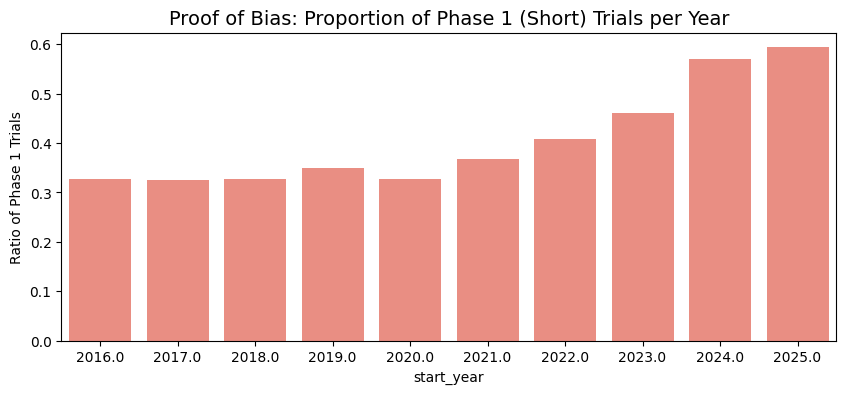

If the bars go UP in 2023/2024, your test set is becoming 'easier' (more short trials).

Running Mitigated Analysis (Phase 2/3 Only, up to 2022)...


/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be en

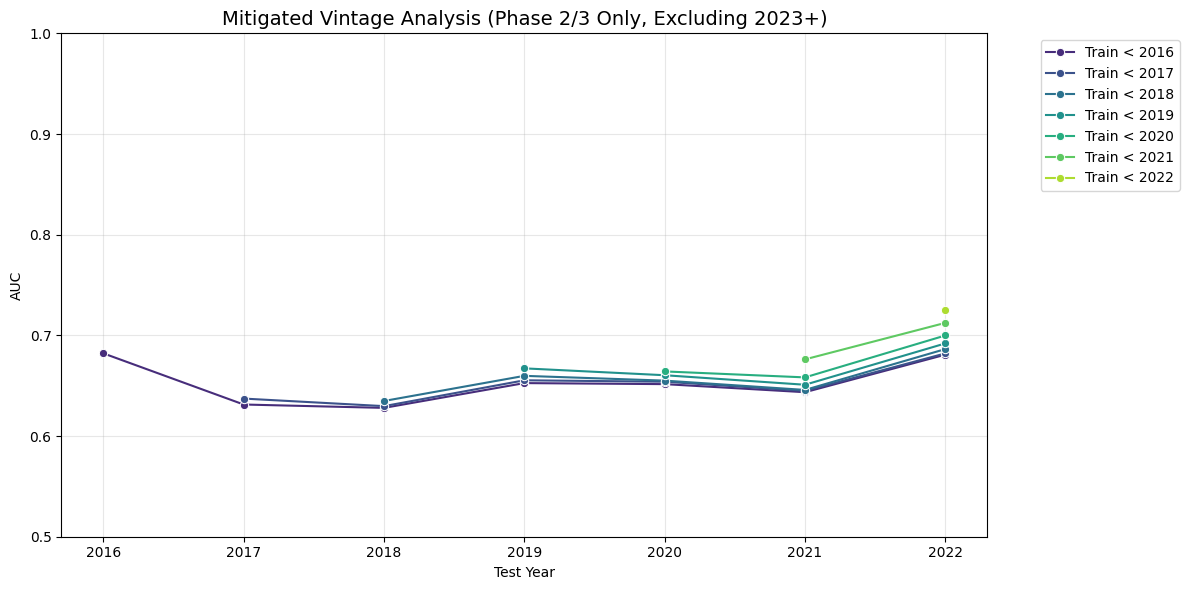

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

# --- PART 1: PROVING THE BIAS ---
# Let's calculate the average duration of trials in your dataset per year
# We approximate duration = (Current Date or Completion Date) - Start Date
# Since we don't have completion date easily available in X_test,
# we can infer "Shortness" by the proportion of Phase 1 trials.

print("Checking for Data Maturity Bias...")
bias_check = df.groupby('start_year')['phase'].apply(lambda x: (x == 'PHASE1').mean()).reset_index(name='Phase1_Ratio')
bias_check = bias_check[bias_check['start_year'] >= 2016]

plt.figure(figsize=(10, 4))
sns.barplot(data=bias_check, x='start_year', y='Phase1_Ratio', color='salmon')
plt.title("Proof of Bias: Proportion of Phase 1 (Short) Trials per Year", fontsize=14)
plt.ylabel("Ratio of Phase 1 Trials")
plt.show()
print("If the bars go UP in 2023/2024, your test set is becoming 'easier' (more short trials).")


# --- PART 2: MITIGATION (Running Analysis on Phase 2/3 Only) ---
# This attempts to compare "Apples to Apples" by removing the short Phase 1s.

def plot_mitigated_vintage(pipeline, df, start_cutoff=2016, iterations=7):
    # NOTE: We stop at 2022 (iterations=7) to avoid the very immature 2023/24 data
    results = []
    cutoffs = [start_cutoff + i for i in range(iterations)]

    print(f"\nRunning Mitigated Analysis (Phase 2/3 Only, up to 2022)...")

    # FILTER: Keep only Phase 2 and 3 for this analysis
    # We assume 'phase' column exists in df.
    # Adjust values based on your specific encoding (e.g., 'PHASE2', 'PHASE3')
    complex_trials_df = df[df['phase'].isin(['PHASE2', 'PHASE3', 'PHASE2/PHASE3'])].copy()

    for cutoff in cutoffs:
        train_mask = complex_trials_df['start_year'] < cutoff
        test_mask = complex_trials_df['start_year'] >= cutoff

        train_df = complex_trials_df[train_mask]
        future_df = complex_trials_df[test_mask]

        if len(future_df) < 50: break

        X_train = train_df.drop(columns=['target', 'overall_status', 'nct_id'])
        y_train = train_df['target']

        current_model = clone(pipeline)
        current_model.fit(X_train, y_train)

        future_years = sorted(future_df['start_year'].unique())

        for test_year in future_years:
            # STOP analysis at 2022 to avoid the "incomplete data" tail
            if test_year > 2022:
                continue

            year_data = future_df[future_df['start_year'] == test_year]

            if len(year_data) < 50 or year_data['target'].nunique() < 2:
                continue

            X_test = year_data.drop(columns=['target', 'overall_status', 'nct_id'])
            y_test = year_data['target']

            probs = current_model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, probs)

            results.append({
                'Model Version': f"Train < {cutoff}",
                'Test Year': int(test_year),
                'AUC': auc
            })

    # Plot
    if not results:
        print("No results. Check your Phase column values.")
        return

    res_df = pd.DataFrame(results)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=res_df, x='Test Year', y='AUC', hue='Model Version', marker='o', palette='viridis')
    plt.title("Mitigated Vintage Analysis (Phase 2/3 Only, Excluding 2023+)", fontsize=14)
    plt.ylim(0.5, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run Mitigation
plot_mitigated_vintage(model, df, start_cutoff=2016, iterations=7)

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Phase           | Count  | Success Rate | Model AUC
-------------------------------------------------------
PHASE2          | 10096  | 66.6%      | 0.6437
PHASE1/PHASE2   | 2712   | 60.3%      | 0.6514
PHASE3          | 5952   | 77.4%      | 0.6508
PHASE1          | 11821  | 81.5%      | 0.7762
PHASE2/PHASE3   | 1174   | 70.5%      | 0.6702


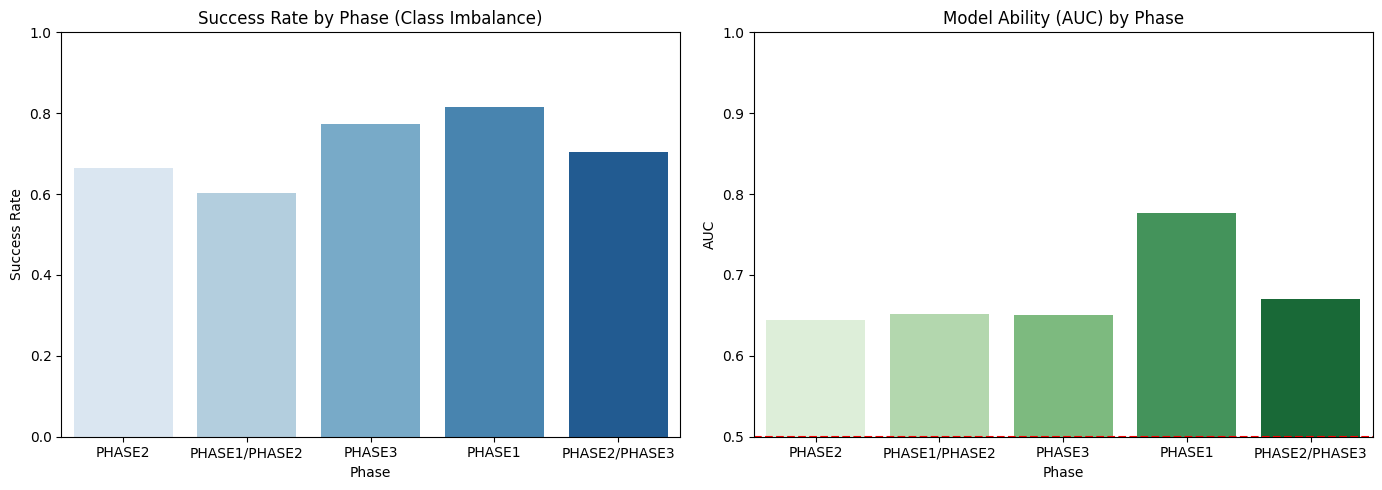

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def analyze_performance_by_phase(model, X_test, y_test, df_original):
    # 1. Recover the 'phase' column
    test_indices = X_test.index
    phases = df_original.loc[test_indices, 'phase']

    # Create analysis dataframe
    analysis_df = pd.DataFrame({
        'phase': phases,
        'target_actual': y_test,
        'pred_prob': model.predict_proba(X_test)[:, 1]
    })

    # 2. Calculate Metrics
    results = []
    unique_phases = analysis_df['phase'].unique()

    print(f"{'Phase':<15} | {'Count':<6} | {'Success Rate':<12} | {'Model AUC':<6}")
    print("-" * 55)

    for ph in unique_phases:
        subset = analysis_df[analysis_df['phase'] == ph]

        if len(subset) < 50:
            continue

        # Success Rate (1 - Failure Rate)
        failure_rate = subset['target_actual'].mean()
        success_rate = 1.0 - failure_rate

        try:
            auc = roc_auc_score(subset['target_actual'], subset['pred_prob'])
        except:
            auc = 0.5

        results.append({
            'Phase': ph,
            'Count': len(subset),
            'Success Rate': success_rate,
            'AUC': auc
        })

        print(f"{ph:<15} | {len(subset):<6} | {success_rate:.1%}      | {auc:.4f}")

    # 3. Visualization
    res_df = pd.DataFrame(results)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Chart 1: Success Rate
    # FIX: Added hue='Phase' and legend=False
    sns.barplot(data=res_df, x='Phase', y='Success Rate', hue='Phase', legend=False, ax=ax[0], palette='Blues')
    ax[0].set_title("Success Rate by Phase (Class Imbalance)")
    ax[0].set_ylim(0, 1.0)

    # Chart 2: Model Performance
    # FIX: Added hue='Phase' and legend=False
    sns.barplot(data=res_df, x='Phase', y='AUC', hue='Phase', legend=False, ax=ax[1], palette='Greens')
    ax[1].set_title("Model Ability (AUC) by Phase")
    ax[1].set_ylim(0.5, 1.0)
    ax[1].axhline(0.5, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

# Run it
analyze_performance_by_phase(model, X_test, y_test, df)

/home/delaunan/.pyenv/versions/clintrialpredict/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Agency Class    | Count  | Success Rate | Model AUC
-------------------------------------------------------
OTHER           | 11123  | 66.3%      | 0.6839
INDUSTRY        | 19482  | 78.2%      | 0.7199
NIH             | 520    | 64.4%      | 0.7280
NETWORK         | 172    | 62.2%      | 0.6710
OTHER_GOV       | 328    | 86.0%      | 0.6451
FED             | 106    | 67.0%      | 0.6592


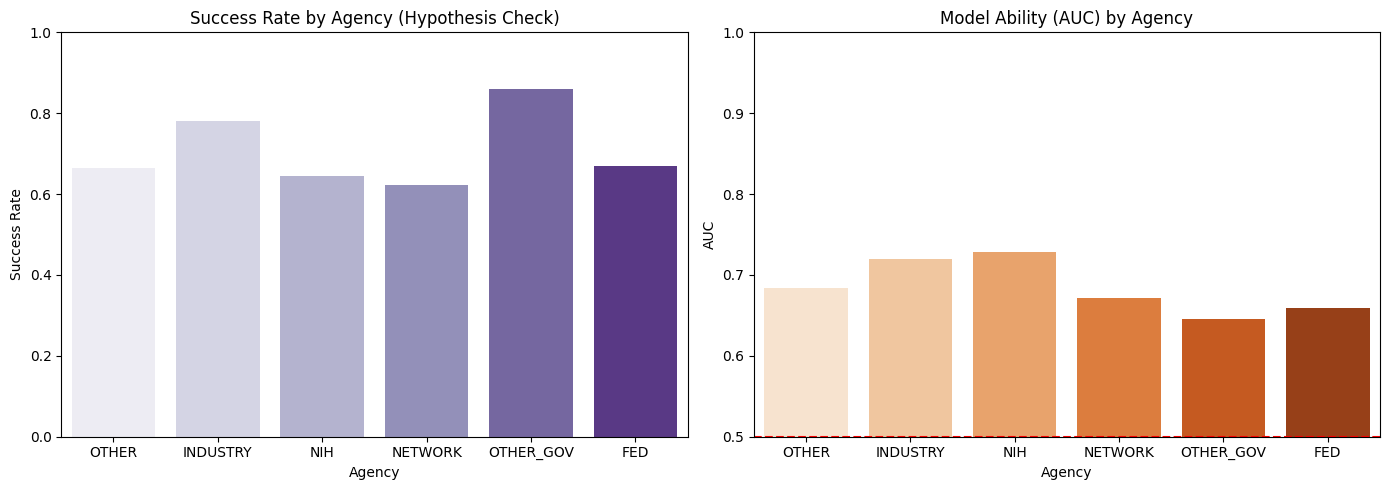

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def analyze_performance_by_agency(model, X_test, y_test, df_original):
    # 1. Recover the 'agency_class' column
    test_indices = X_test.index
    # Note: Ensure 'lead_or_collaborator' filter in data_loader didn't lose this
    # We assume 'agency_class' is available in df_original
    agencies = df_original.loc[test_indices, 'agency_class']

    analysis_df = pd.DataFrame({
        'agency_class': agencies,
        'target_actual': y_test,
        'pred_prob': model.predict_proba(X_test)[:, 1]
    })

    # 2. Calculate Metrics
    results = []
    unique_agencies = analysis_df['agency_class'].unique()

    print(f"{'Agency Class':<15} | {'Count':<6} | {'Success Rate':<12} | {'Model AUC':<6}")
    print("-" * 55)

    for agency in unique_agencies:
        subset = analysis_df[analysis_df['agency_class'] == agency]

        if len(subset) < 50: continue

        success_rate = 1.0 - subset['target_actual'].mean()

        try:
            auc = roc_auc_score(subset['target_actual'], subset['pred_prob'])
        except:
            auc = 0.5

        results.append({
            'Agency': agency,
            'Count': len(subset),
            'Success Rate': success_rate,
            'AUC': auc
        })

        print(f"{agency:<15} | {len(subset):<6} | {success_rate:.1%}      | {auc:.4f}")

    # 3. Visualization
    res_df = pd.DataFrame(results)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Chart 1: Success Rate
    sns.barplot(data=res_df, x='Agency', y='Success Rate', hue='Agency', legend=False, ax=ax[0], palette='Purples')
    ax[0].set_title("Success Rate by Agency (Hypothesis Check)")
    ax[0].set_ylim(0, 1.0)

    # Chart 2: Model Performance
    sns.barplot(data=res_df, x='Agency', y='AUC', hue='Agency', legend=False, ax=ax[1], palette='Oranges')
    ax[1].set_title("Model Ability (AUC) by Agency")
    ax[1].set_ylim(0.5, 1.0)
    ax[1].axhline(0.5, color='red', linestyle='--')

    plt.tight_layout()
    plt.show()

# Run it
analyze_performance_by_agency(model, X_test, y_test, df)

In [17]:
import joblib
import os

# 1. Define the Output Directory
# We use 'project_root' from Cell 1.
models_dir = os.path.join(project_root, 'models')

# 2. Create directory if it doesn't exist
os.makedirs(models_dir, exist_ok=True)

# 3. Define Path & Save
model_filename = 'baseline_pipeline.joblib'
model_path = os.path.join(models_dir, model_filename)

joblib.dump(model, model_path)

# 4. Verification
print(f">>> SUCCESS: Model saved to {model_path}")
# Check size to ensure it's not empty (e.g., < 1KB would be suspicious)
print(f"    File Size: {os.path.getsize(model_path) / 1024:.2f} KB")

>>> SUCCESS: Model saved to /home/delaunan/code/delaunan/clintrialpredict/models/baseline_pipeline.joblib
    File Size: 303.27 KB


In [18]:
import pandas as pd
import os

# 1. Setup Path (Adjust DATA_PATH if needed, usually defined in previous cells)
# If DATA_PATH is not defined, replace it with your actual path string like 'data/raw'
sponsors_file = os.path.join(DATA_PATH, 'sponsors.txt')

print(f">>> Loading Lead Sponsors from: {sponsors_file}")

# 2. Load Raw Sponsors File
# We only need 3 columns. 'on_bad_lines' helps skip broken rows in the text file.
df_sponsors = pd.read_csv(
    sponsors_file,
    sep='|',
    usecols=['nct_id', 'lead_or_collaborator', 'name'],
    on_bad_lines='skip',
    low_memory=False
)

# 3. Filter for LEAD sponsors only
# We don't want to duplicate rows by including every collaborator.
df_leads = df_sponsors[df_sponsors['lead_or_collaborator'].str.lower() == 'lead'].copy()

# 4. Clean up
# Rename 'name' to 'lead_sponsor' to be specific
df_leads = df_leads.rename(columns={'name': 'lead_sponsor'})

# Drop duplicates: In rare cases, a trial lists the same lead sponsor twice.
# We keep the first one to ensure 1 row per nct_id.
df_leads = df_leads.drop_duplicates(subset=['nct_id'])

# Keep only relevant columns for the merge
df_leads = df_leads[['nct_id', 'lead_sponsor']]

# 5. Merge into your Main Dataframe (df)
# We use 'left' join so we don't lose any trials from your main df
if 'lead_sponsor' in df.columns:
    print("Column 'lead_sponsor' already exists. Dropping it to refresh...")
    df = df.drop(columns=['lead_sponsor'])

df = df.merge(df_leads, on='nct_id', how='left')

# 6. Fill Missing Values
# If a trial has no lead sponsor listed (rare), we call it 'UNKNOWN'
df['lead_sponsor'] = df['lead_sponsor'].fillna('UNKNOWN')

print(f"✅ Success! Added 'lead_sponsor' column.")
print(f"    New Dataframe Shape: {df.shape}")
print(f"    Sample Values:\n{df[['nct_id', 'lead_sponsor']].head()}")

>>> Loading Lead Sponsors from: /home/delaunan/code/delaunan/clintrialpredict/data/sponsors.txt
Column 'lead_sponsor' already exists. Dropping it to refresh...
✅ Success! Added 'lead_sponsor' column.
    New Dataframe Shape: (105850, 36)
    Sample Values:
        nct_id                                       lead_sponsor
0  NCT00315614                                University of Miami
1  NCT00226616  International Centre for Diarrhoeal Disease Re...
2  NCT00004255                                 Chimeric Therapies
3  NCT00005988                       Dana-Farber Cancer Institute
4  NCT00004144              Barbara Ann Karmanos Cancer Institute


In [27]:
import pandas as pd
import numpy as np
import re

def optimize_sponsor_data(df, col='lead_sponsor'):
    print(">>> OPTIMIZING SPONSOR DATA...")

    # 1. PRE-CLEANING (Vectorized String Operations)
    # Lowercase, strip, remove legal entities (Inc, LLC, Ltd)
    # We use a single regex for speed
    print("    -> Step 1: Removing legal suffixes...")
    clean_col = df[col].astype(str).str.lower().str.strip()

    # Regex to remove common legal endings and punctuation
    # \b ensures we match whole words (so we don't delete 'incorporation' inside a word)
    legal_entity_pattern = r'[.,]|\binc\b|\bltd\b|\bllc\b|\bcorp\b|\bgmbh\b|\bsa\b|\bplc\b|\bnv\b'
    clean_col = clean_col.str.replace(legal_entity_pattern, '', regex=True).str.strip()

    # 2. STANDARDIZATION DICTIONARY (The "Big Pharma" Map)
    # Maps keywords to the canonical Company Name
    print("    -> Step 2: Mapping Big Pharma & Institutions...")

    # Dictionary format: { 'Standardized Name': [list of keywords to trigger it] }
    # Order matters slightly less here as we will prioritize specific matches
    mappings = {
        'Pfizer': ['pfizer', 'wyeth', 'hospira', 'pharmacia'],
        'GSK': ['glaxo', 'gsk', 'smithkline'],
        'Novartis': ['novartis', 'sandoz', 'alcon'],
        'AstraZeneca': ['astrazeneca', 'medimmune'],
        'Merck': ['merck', 'msd', 'schering-plough'],
        'Roche': ['roche', 'genentech', 'hoffmann', 'chugai'],
        'Sanofi': ['sanofi', 'aventis', 'genzyme'],
        'J&J': ['johnson & johnson', 'janssen', 'ethicon'],
        'Bayer': ['bayer', 'monsanto'],
        'Boehringer Ingelheim': ['boehringer'],
        'BMS': ['bristol-myers', 'squibb', 'celgene'],
        'Eli Lilly': ['lilly'],
        'Abbott/AbbVie': ['abbott', 'abbvie'],
        'Amgen': ['amgen', 'onyx'],
        'Takeda': ['takeda', 'shire', 'millennium'],
        'Gilead': ['gilead', 'kite'],
        'Novo Nordisk': ['novo nordisk'],
        'NIH/NCI': ['national cancer institute', 'nci', 'national institutes of health', 'nih', 'nhlbi'],
        'Mayo Clinic': ['mayo clinic']
    }

    # Apply mappings
    # We create a copy to avoid SettingWithCopy warnings
    final_names = clean_col.copy()

    for standard_name, keywords in mappings.items():
        # Create a regex pattern like: "pfizer|wyeth|hospira"
        pattern = '|'.join(keywords)
        # If the cleaned name contains the pattern, overwrite it with Standard Name
        mask = clean_col.str.contains(pattern, case=False, regex=True)
        final_names.loc[mask] = standard_name

    df['sponsor_clean'] = final_names

    # 3. TIERING (The Power Feature)
    print("    -> Step 3: Calculating Sponsor Tiers...")

    # Count trials per standardized sponsor
    counts = df['sponsor_clean'].value_counts()

    # Define Thresholds
    # Top 1%: The Giants who define the industry standards
    top_1_percent_cutoff = counts.quantile(0.99)

    def get_tier(name):
        count = counts.get(name, 0)

        # Priority 1: Is it a mapped Big Pharma? (Even if count is low in this specific slice)
        if name in mappings.keys():
            return 'TIER_1_GIANT'

        # Priority 2: Is it a high volume sponsor?
        if count >= 50: # Arbitrary but robust threshold for "Experienced"
            return 'TIER_1_GIANT'
        elif count >= 10:
            return 'TIER_2_ESTABLISHED'
        elif count >= 2:
            return 'TIER_3_SMALL'
        else:
            return 'TIER_4_ONE_OFF' # Sponsors with only 1 trial

    df['sponsor_tier'] = df['sponsor_clean'].apply(get_tier)

    # 4. EXPERIENCE LOG (Continuous Feature)
    # Log(Count + 1) to handle the massive skew
    df['sponsor_experience_log'] = np.log1p(df['sponsor_clean'].map(counts))

    print(f"    ✅ DONE. Reduced {df[col].nunique()} raw names to {df['sponsor_clean'].nunique()} standardized names.")

    return df

# --- RUN THE CLEANING ---
# Assuming 'df' is your main dataframe
df = optimize_sponsor_data(df)

>>> OPTIMIZING SPONSOR DATA...
    -> Step 1: Removing legal suffixes...
    -> Step 2: Mapping Big Pharma & Institutions...
    -> Step 3: Calculating Sponsor Tiers...
    ✅ DONE. Reduced 11590 raw names to 11388 standardized names.


In [28]:
def summarize_sponsor_engineering(df):
    print("\n=== SPONSOR ENGINEERING SUMMARY ===")

    # 1. Tier Distribution
    tier_counts = df['sponsor_tier'].value_counts()
    tier_pct = df['sponsor_tier'].value_counts(normalize=True) * 100

    print("\n1. Distribution of Trials by Sponsor Tier:")
    print(f"{'Tier':<20} | {'Trials':<8} | {'% of Data':<10}")
    print("-" * 45)
    for tier, count in tier_counts.items():
        pct = tier_pct[tier]
        print(f"{tier:<20} | {count:<8} | {pct:.1f}%")

    # 2. Success Rate by Tier (The "Why this matters" check)
    # Assuming 'target' exists (0=Success/Completed, 1=Failure/Terminated)
    if 'target' in df.columns:
        print("\n2. Success Rate by Tier (Hypothesis Check):")
        print(f"{'Tier':<20} | {'Success Rate':<10}")
        print("-" * 35)
        for tier in tier_counts.index:
            # Calculate success (1 - failure mean)
            success = 1.0 - df[df['sponsor_tier'] == tier]['target'].mean()
            print(f"{tier:<20} | {success:.1%}")

    # 3. Top Movers (Who got merged?)
    print("\n3. Standardization Impact:")
    print(f"Raw Unique Names:   {df['lead_sponsor'].nunique()}")
    print(f"Clean Unique Names: {df['sponsor_clean'].nunique()}")
    print(f"Compression Ratio:  {(1 - df['sponsor_clean'].nunique()/df['lead_sponsor'].nunique()):.1%} reduction in noise")

# Run Summary
summarize_sponsor_engineering(df)


=== SPONSOR ENGINEERING SUMMARY ===

1. Distribution of Trials by Sponsor Tier:
Tier                 | Trials   | % of Data 
---------------------------------------------
TIER_1_GIANT         | 60267    | 57.2%
TIER_2_ESTABLISHED   | 22385    | 21.3%
TIER_3_SMALL         | 17300    | 16.4%
TIER_4_ONE_OFF       | 5384     | 5.1%

2. Success Rate by Tier (Hypothesis Check):
Tier                 | Success Rate
-----------------------------------
TIER_1_GIANT         | 81.6%
TIER_2_ESTABLISHED   | 80.5%
TIER_3_SMALL         | 79.3%
TIER_4_ONE_OFF       | 75.3%

3. Standardization Impact:
Raw Unique Names:   11590
Clean Unique Names: 11388
Compression Ratio:  1.7% reduction in noise


In [19]:
import pandas as pd
import numpy as np

print("=== 🩺 SYSTEM HEALTH CHECK ===")

# 1. CHECK WEIGHTS
print("\n1. Checking Sample Weights...")
if 'sample_weight' in df.columns:
    p3_weight = df[df['phase'] == 'PHASE3']['sample_weight'].mean()
    p1_weight = df[df['phase'] == 'PHASE1']['sample_weight'].mean()
    print(f"   Phase 3 Avg Weight: {p3_weight} (Should be 2.0)")
    print(f"   Phase 1 Avg Weight: {p1_weight} (Should be 1.0)")
    if p3_weight > p1_weight: print("   ✅ Weights are correctly applied.")
    else: print("   ❌ Weights look wrong.")
else:
    print("   ❌ 'sample_weight' column missing!")

# 2. CHECK SPONSOR TIERS
print("\n2. Checking Sponsor Tiers...")
if 'sponsor_tier' in df.columns:
    counts = df['sponsor_tier'].value_counts()
    print(f"   Tiers Found: {len(counts)}")
    print(f"   Tier 1 (Giants) Count: {counts.get('TIER_1_GIANT', 0)}")
    if 'TIER_1_GIANT' in counts: print("   ✅ Tiers are generated.")
    else: print("   ❌ Tiers look empty.")
else:
    print("   ❌ 'sponsor_tier' column missing!")

# 3. CHECK COMPLEXITY
print("\n3. Checking Complexity Feature...")
if 'criteria_len_log' in df.columns:
    avg_len = df['criteria_len_log'].mean()
    print(f"   Avg Log Length: {avg_len:.2f}")
    if avg_len > 0: print("   ✅ Criteria length calculated.")
    else: print("   ❌ Criteria length is all zero (Did eligibilities.txt load?)")
else:
    print("   ❌ 'criteria_len_log' column missing!")

# 4. CHECK LEAKAGE (Country Count)
print("\n4. Checking for Leakage...")
if 'country_count' in df.columns:
    print("   ❌ WARNING: 'country_count' is present. Ensure it is NOT in the pipeline features list.")
else:
    print("   ✅ 'country_count' correctly removed (using 'is_international' instead).")

print("\n=== END CHECK ===")

=== 🩺 SYSTEM HEALTH CHECK ===

1. Checking Sample Weights...
   Phase 3 Avg Weight: 2.0 (Should be 2.0)
   Phase 1 Avg Weight: 1.0 (Should be 1.0)
   ✅ Weights are correctly applied.

2. Checking Sponsor Tiers...
   Tiers Found: 4
   Tier 1 (Giants) Count: 60455
   ✅ Tiers are generated.

3. Checking Complexity Feature...
   Avg Log Length: 7.45
   ✅ Criteria length calculated.

4. Checking for Leakage...
   ✅ 'country_count' correctly removed (using 'is_international' instead).

=== END CHECK ===
